# Let's segment a variety of clothing types!
# import modules and define utils

In [1]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
print(os.listdir("/Users/markmcdonald/Desktop/FashionDataSet"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns

['label_descriptions.json', '.DS_Store', 'test', 'imaterialist-fashion-2019-FGVC6.zip', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
input_dir = "/Users/markmcdonald/Desktop/FashionDataSet/"

In [3]:
def classid2label(class_id):
    category, *attribute = class_id.split("_")
    return category, attribute

In [4]:
def print_dict(dictionary, name_dict):
    print("{}{}{}{}{}".format("rank".ljust(5), "id".center(8), "name".center(40), "amount".rjust(10), "ratio(%)".rjust(10)))
    all_num = sum(dictionary.values())
    for i, (key, val) in enumerate(sorted(dictionary.items(), key=lambda x: -x[1])):
        print("{:<5}{:^8}{:^40}{:>10}{:>10.3%}".format(i+1, key, name_dict[key], val, val/all_num))

In [5]:
def print_img_with_labels(img_name, labels, category_name_dict, attribute_name_dict, ax):
    img = np.asarray(Image.open(input_dir + "train/" + img_name))
    label_interval = (img.shape[0] * 0.9) / len(labels)
    ax.imshow(img)
    for num, attribute_id in enumerate(labels):
        x_pos = img.shape[1] * 1.1
        y_pos = (img.shape[0] * 0.9) / len(labels) * (num + 2) + (img.shape[0] * 0.1)
        if(num == 0):
            ax.text(x_pos, y_pos-label_interval*2, "category", fontsize=12)
            ax.text(x_pos, y_pos-label_interval, category_name_dict[attribute_id], fontsize=12)
            if(len(labels) > 1):
                ax.text(x_pos, y_pos, "attribute", fontsize=12)
        else:
            ax.text(x_pos, y_pos, attribute_name_dict[attribute_id], fontsize=12)

In [6]:
def print_img(img_name, ax):
    img_df = train_df[train_df.ImageId == img_name]
    labels = list(set(img_df["ClassId"].values))
    print_img_with_labels(img_name, labels, category_name_dict, attribute_name_dict, ax)

In [7]:
def json2df(data):
    df = pd.DataFrame()
    for index, el in enumerate(data):
        for key, val in el.items():
            df.loc[index, key] = val
    return df

# check Text Data
* train.csv  
Training annotations, contains images with both segmented apparel categories and fine-grained attributes; and images with segmented apparel categories only.

    * `ImageID` : the unique Id of an image
    * `EncodedPixels` : masks in **run-length encoded format** (please refer to [evaluation page](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/overview/evaluation) for details).  
        * `run-length encoded format` : In summary, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask.  
        (The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.)
    * `ClassId` : the class id for this mask. We concatenate both category and attributes (if any) together.

In [8]:
input_dir + "train.csv"

'/Users/markmcdonald/Desktop/FashionDataSet/train.csv'

In [9]:
train_df = pd.read_csv(input_dir + "train.csv")

In [33]:
train_df.iloc[0].ImageId

'00000663ed1ff0c4e0132b9b9ac53f6e.jpg'

In [37]:
train_df.sort_values(by='ClassId')

,ImageId,EncodedPixels,Height,Width,ClassId
204278,9cd8303a79ffcfc2166737689d103592.jpg,958422 1 959423 3 960424 4 961425 6 962426 7 9...,1000,1500,0
23160,11dcc1fb5c690831d234d8069719bcec.jpg,65153 1 66174 1 67195 1 70257 1 71278 1 72299 ...,1021,680,0
266674,cd33bd1b90bb3a88f33f4b218a3924a6.jpg,370266 1 371663 5 373060 9 374457 13 375854 17...,1400,1400,0
145049,6f6d40fe37d0ecd44ef4153015037868.jpg,795933 4 798929 9 801928 10 804928 11 807928 1...,3000,2000,0
205576,9dc7ea556a5d0ccc17a14bd516651338.jpg,1160420 2 1163419 6 1166418 10 1169417 15 1172...,3000,2001,0
...,...,...,...,...,...
321566,f71e69c1823525251dc2201172364595.jpg,319422 4 320951 4 321015 12 322548 13 322608 2...,1600,1067,9_9_20_42_49_62_91
257658,c62ad5522ae2cce8042ee54682f1a22e.jpg,316434 1 318032 4 319630 7 321229 8 322827 11 ...,1600,1067,9_9_20_42_55_62_91
282985,d994904aaec72399c79634b27ea6b0ea.jpg,184041 12 184705 27 185369 32 186034 36 186698...,667,1000,9_9_20_43_60_72_91
324222,f9290a63d1667c6aa712700d65590066.jpg,276474 1 277139 3 277805 4 278470 6 279136 7 2...,667,1000,9_9_20_43_60_72_91


In [29]:
class_ids = train_df.ClassId
len(np.unique(class_ids.values))

6371

A image have some ClassID.  
Next, check the label description.  
After that, let's check the number of labels in each images and look some images.  

* label_descriptions.json  
A file giving the apparel categories and fine-grained attributes descriptions.

In [14]:
with open(input_dir + "label_descriptions.json") as f:
    label_description = json.load(f)

In [17]:
label_description

{'info': {'year': 2019,
  'version': '1.0',
  'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.',
  'contributor': 'iMaterialist Fashion Competition group',
  'url': 'https://github.com/visipedia/imat_comp',
  'date_created': '2019-04-19 12:38:27.493919'},
 'categories': [{'id': 0,
   'name': 'shirt, blouse',
   'supercategory': 'upperbody',
   'level': 2},
  {'id': 1,
   'name': 'top, t-shirt, sweatshirt',
   'supercategory': 'upperbody',
   'level': 2},
  {'id': 2, 'name': 'sweater', 'supercategory': 'upperbody', 'level': 2},
  {'id': 3, 'name': 'cardigan', 'supercategory': 'upperbody', 'level': 2},
  {'id': 4, 'name': 'jacket', 'supercategory': 'upperbody', 'level': 2},
  {'id': 5, 'name': 'vest', 'supercategory': 'upperbody', 'level': 2},
  {'id': 6, 'name': 'pants', 'supercategory': 'lowerbody', 'level': 2},
  {'id': 7, 'name': 'shorts', 'supercategory': 'lowerbody', 'level': 2},
  {'id': 8, 'name': 'skirt', 'supercategory': 'lowerbody', 'level': 2}

In [18]:
print("this dataset info")
print(json.dumps(label_description["info"], indent=2))

this dataset info
{
  "year": 2019,
  "version": "1.0",
  "description": "The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.",
  "contributor": "iMaterialist Fashion Competition group",
  "url": "https://github.com/visipedia/imat_comp",
  "date_created": "2019-04-19 12:38:27.493919"
}


In [19]:
category_df = json2df(label_description["categories"])
category_df["id"] = category_df["id"].astype(int)
category_df["level"] = category_df["level"].astype(int)
attribute_df = json2df(label_description["attributes"])
attribute_df["id"] = attribute_df["id"].astype(int)
attribute_df["level"] = attribute_df["level"].astype(int)

In [20]:
print("Category Labels")
category_df

Category Labels


,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [21]:
print("Attribute Labels")
attribute_df

Attribute Labels


,id,name,supercategory,level
0,0,above-the-hip (length),length,1
1,1,hip (length),length,1
2,2,micro (length),length,1
3,3,mini (length),length,1
4,4,above-the-knee (length),length,1
5,5,knee (length),length,1
6,6,below the knee (length),length,1
7,7,midi,length,1
8,8,maxi (length),length,1
9,9,floor (length),length,1


In [22]:
print("We have {} categories, and {} attributes.".format(len(label_description['categories']), len(label_description['attributes'])))
print("Each label　have ID, name, supercategory, and level.")

We have 46 categories, and 92 attributes.
Each label　have ID, name, supercategory, and level.


We have 46 categories, and 92 attributes.  
Each label have ID, name, supercategory, and level.  
I do not know what **level** represents.  

Let's check the number of labels in each images and look some images!  

In [23]:
train_df.head(10)

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32
5,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,11464158 10 11469372 30 11474586 43 11479800 4...,5214,3676,32
6,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5910568 31 5915775 65 5920982 69 5926189 73 59...,5214,3676,31
7,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676,29
8,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4
9,0000fe7c9191fba733c8a69cfaf962b7.jpg,2201176 1 2203623 3 2206071 5 2208518 8 221096...,2448,2448,33


In [24]:
image_label_num_df = train_df.groupby("ImageId")["ClassId"].count()

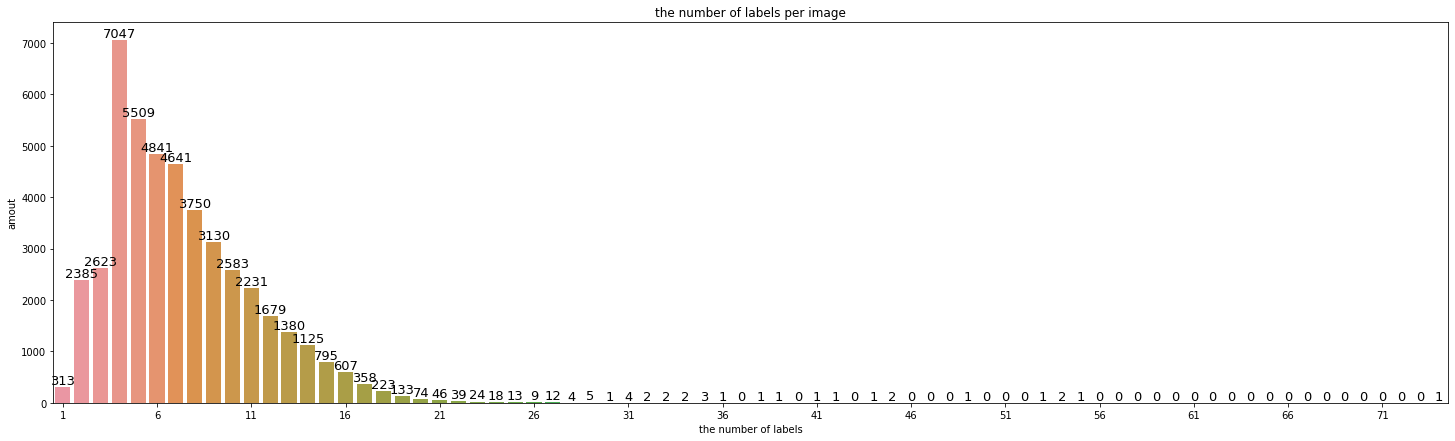

In [25]:
fig, ax = plt.subplots(figsize=(25, 7))
x = image_label_num_df.value_counts().index.values
y = image_label_num_df.value_counts().values
z = zip(x, y)
z = sorted(z)
x, y = zip(*z)
index = 0
x_list = []
y_list = []
for i in range(1, max(x)+1):
    if(i not in x):
        x_list.append(i)
        y_list.append(0)
    else:
        x_list.append(i)
        y_list.append(y[index])
        index += 1
for i, j in zip(x_list, y_list):
    ax.text(i-1, j, j, ha="center", va="bottom", fontsize=13)
sns.barplot(x=x_list, y=y_list, ax=ax)
ax.set_xticks(list(range(0, len(x_list), 5)))
ax.set_xticklabels(list(range(1, len(x_list), 5)))
ax.set_title("the number of labels per image")
ax.set_xlabel("the number of labels")
ax.set_ylabel("amout");

Most image have about 1-17 labels.  
But some image have too many labels about over 20.  
Max label in a image is 74!  

In [29]:
counter_category = Counter()
counter_attribute = Counter()
for class_id in train_df["ClassId"]:
    category, attribute = classid2label(class_id)
    counter_category.update([category])
    counter_attribute.update(attribute)

In [30]:
len(counter_category)

46

In [31]:
len(counter_attribute)

92

All kinds of label is in the train dataset.  

In [32]:
category_name_dict = {}
for i in label_description["categories"]:
    category_name_dict[str(i["id"])] = i["name"]
attribute_name_dict = {}
for i in label_description["attributes"]:
    attribute_name_dict[str(i["id"])] = i["name"]

In [33]:
print("Category label frequency")
print_dict(counter_category, category_name_dict)

Category label frequency
rank    id                     name                      amount  ratio(%)
1       31                    sleeve                      59452   17.831%
2       23                     shoe                       46374   13.909%
3       33                   neckline                     34260   10.275%
4       32                    pocket                      27179    8.152%
5       10                    dress                       18739    5.620%
6       1            top, t-shirt, sweatshirt             16550    4.964%
7       6                     pants                       12415    3.724%
8       28                    collar                      10160    3.047%
9       35                    zipper                       7994    2.398%
10      4                     jacket                       7833    2.349%
11      24                 bag, wallet                     7217    2.165%
12      19                     belt                        6851    2.055%
13      0    

In [34]:
print("Attribute label frequency")
print_dict(counter_attribute, attribute_name_dict)

Attribute label frequency
rank    id                     name                      amount  ratio(%)
1       20                 symmetrical                    10773   15.018%
2       61               plain (pattern)                   8719   12.155%
3       60      no special manufacturing technique         6396    8.917%
4       41                regular (fit)                    3676    5.125%
5       88                 normal waist                    3569    4.975%
6       91                 no waistline                    2989    4.167%
7       14                    zip-up                       2872    4.004%
8       0             above-the-hip (length)               2716    3.786%
9       40                 tight (fit)                     2224    3.100%
10      3                 mini (length)                    1951    2.720%
11      87                  high waist                     1740    2.426%
12      15                fly (opening)                    1650    2.300%
13      33  

Category of 17% in training set is `sleeve`.  
Least category is `leg warmer`(112/0.034%).But 112 images, not too few.  
Attribute of 15% in training set is `symmetrical`.  
Least attribute is `burnout`(3/0.004%). OMG....only 3  

In [35]:
train_df.ClassId.max()

'9_9_20_43_61_91'

I have to pay enough attention to `ClassId`.  
`ClassId` is represented　by concatenated both category and attributes (if any) together.  
So, we need to predict category and attribute (if any).  
All `ClassId` have one category and 0 or more attributes.  

9_9_20_43_61_91 means `category: 9`, `attributes: 9, 20, 43, 61, and 91`  
you can see this information in competition [Overview/Evaluation/ClassId](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/overview/evaluation).  

Let's check the ratio of attribute per category.  

In [36]:
attribute_num_dict = {}
none_key = str(len(counter_attribute))
k = list(map(str, range(len(counter_attribute) + 1)))
v = [0] * (len(counter_attribute) + 1)
zipped = zip(k, v)
init_dict = dict(zipped)
for class_id in train_df["ClassId"].values:
    category, attributes = classid2label(class_id)
    if category not in attribute_num_dict.keys():
        attribute_num_dict[category] = init_dict.copy()
    if attributes == []:
        attribute_num_dict[category][none_key] += 1
        continue
    for attribute in attributes:
        attribute_num_dict[category][attribute] += 1

the ratio of attribute per category(x=92 means no attribute)


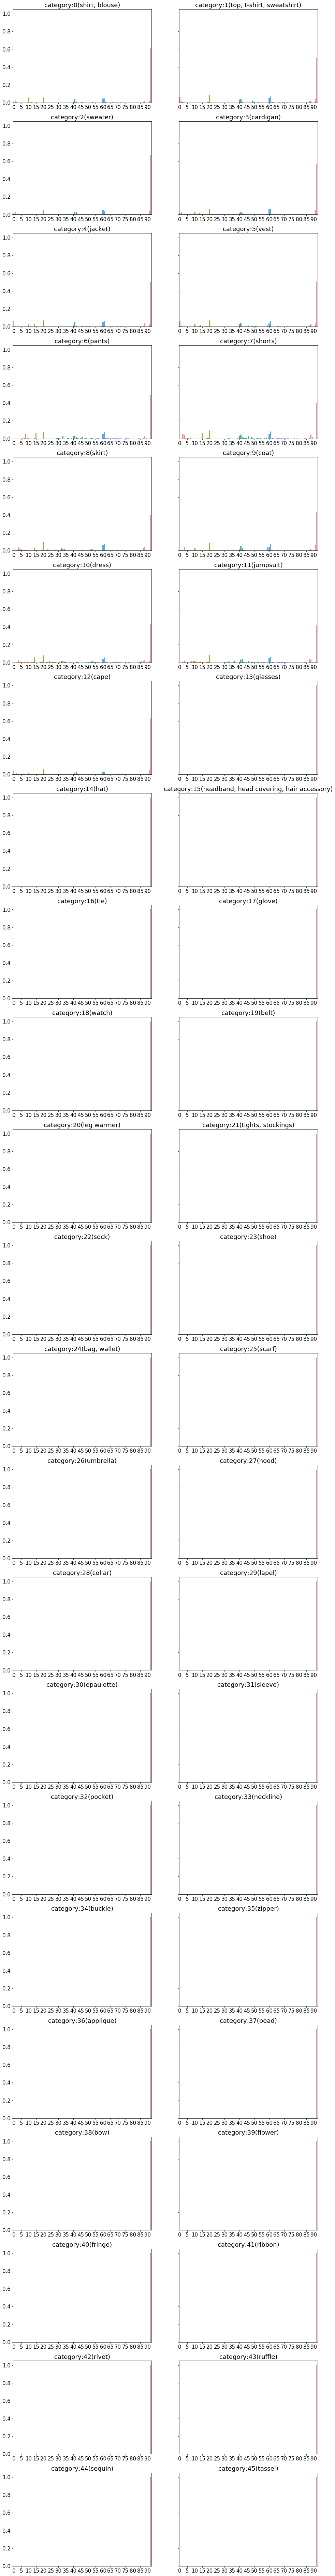

In [37]:
fig, ax = plt.subplots(math.ceil(len(counter_category)/2), 2,\
                       figsize=(8*2, 6*math.ceil(len(counter_category)/2)), sharey=True)
for index, key in enumerate(sorted(map(int, attribute_num_dict.keys()))):
    x = list(map(int, attribute_num_dict[str(key)].keys()))
    total = sum(attribute_num_dict[str(key)].values())
    y = list(map(lambda x: x / total, attribute_num_dict[str(key)].values()))
    sns.barplot(x, y, ax=ax[index//2, index%2])
    ax[index//2, index%2].set_title("category:{}({})".format(key, category_name_dict[str(key)]))
    ax[index//2, index%2].set_xticks(list(range(0, int(none_key), 5)))
    ax[index//2, index%2].set_xticklabels(list(range(0, int(none_key), 5)))
print("the ratio of attribute per category(x=92 means no attribute)")

Wow!  
Many category don't have any attribute.  

# Check Image data
Let's check the number of image!

In [44]:
print("The number of training image is {}.".format(len(os.listdir(input_dir + "train"))))
print("The number of test image is {}.".format(len(os.listdir(input_dir + "test"))))

The number of training image is 45627.
The number of test image is 3201.


Let's check image size!

In [45]:
image_shape_df = train_df.groupby("ImageId")["Height", "Width"].first()

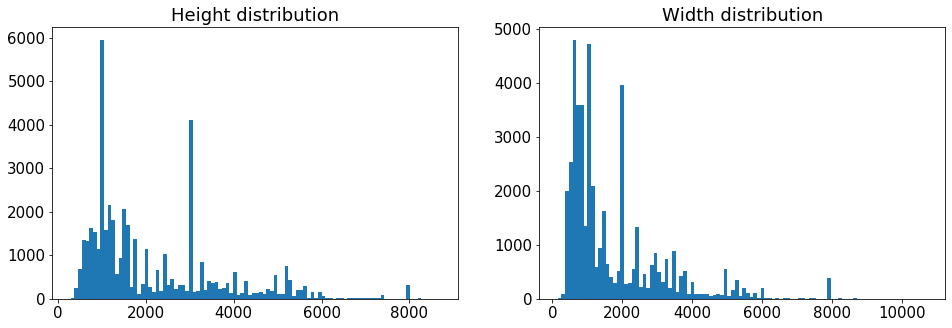

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(image_shape_df.Height, bins=100)
ax1.set_title("Height distribution")
ax2.hist(image_shape_df.Width, bins=100)
ax2.set_title("Width distribution");

Minimam height image is 671cb261d0f1e522c1af51e2630b8631.jpg,
(H, W) = (296, 331)


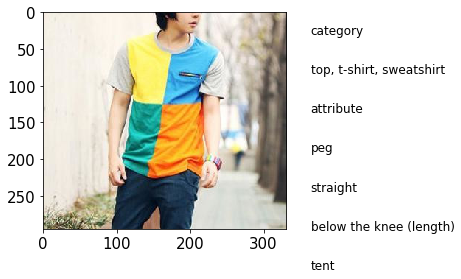

In [47]:
img_name = image_shape_df.Height.idxmin()
height, width = image_shape_df.loc[img_name, :]
print("Minimam height image is {},\n(H, W) = ({}, {})".format(img_name, height, width))
fig, ax = plt.subplots()
print_img(img_name, ax)

Maximum height image is 057929711659b06bfdfa48150c2c5231.jpg,
(H, W) = (8688, 5792)


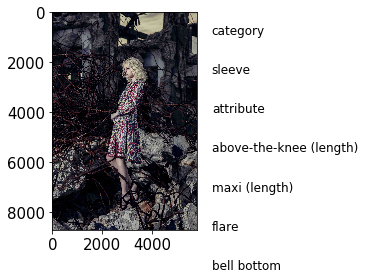

In [48]:
img_name = image_shape_df.Height.idxmax()
height, width = image_shape_df.loc[img_name, :]
print("Maximum height image is {},\n(H, W) = ({}, {})".format(img_name, height, width))
fig, ax = plt.subplots()
print_img(img_name, ax)

Minimam width image is 35d38009d1e38bd0fa81866aab9fa32d.jpg,
(H, W) = (499, 151)


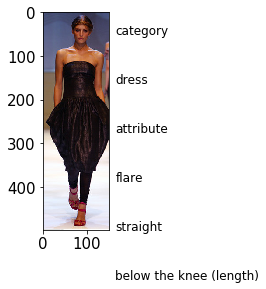

In [49]:
img_name = image_shape_df.Width.idxmin()
height, width = image_shape_df.loc[img_name, :]
print("Minimam width image is {},\n(H, W) = ({}, {})".format(img_name, height, width))
fig, ax = plt.subplots()
print_img(img_name, ax)

Maximum width image is 7ccae737f64205acf152c4d66437b4ba.jpg,
(H, W) = (6824, 10717)


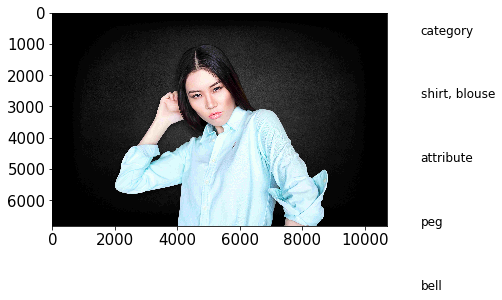

In [50]:
img_name = image_shape_df.Width.idxmax()
height, width = image_shape_df.loc[img_name, :]
print("Maximum width image is {},\n(H, W) = ({}, {})".format(img_name, height, width))
fig, ax = plt.subplots()
print_img(img_name, ax)

Next, let's show segmented images.  

In [51]:
pallete =  [
    'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
    'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']


def make_mask_img(segment_df):
    category_num = len(counter_category)
    seg_width = segment_df.at[0, "Width"]
    seg_height = segment_df.at[0, "Height"]
    seg_img = np.full(seg_width*seg_height, category_num-1, dtype=np.uint8)
    for encoded_pixels, class_id in zip(segment_df["EncodedPixels"].values, segment_df["ClassId"].values):
        pixel_list = list(map(int, encoded_pixels.split(" ")))
        for i in range(0, len(pixel_list), 2):
            start_index = pixel_list[i] - 1
            index_len = pixel_list[i+1] - 1
            seg_img[start_index:start_index+index_len] =\
                int(int(class_id.split("_")[0]) / (category_num-1) * 255)
    seg_img = seg_img.reshape((seg_height, seg_width), order='F')
    return seg_img


def train_generator(df, batch_size):
    img_ind_num = df.groupby("ImageId")["ClassId"].count()
    index = df.index.values[0]
    trn_images = []
    seg_images = []
    for i, (img_name, ind_num) in enumerate(img_ind_num.items()):
        img = cv2.imread("../input/train/" + img_name)
        segment_df = (df.loc[index:index+ind_num-1, :]).reset_index(drop=True)
        index += ind_num
        if segment_df["ImageId"].nunique() != 1:
            raise Exception("Index Range Error")
        seg_img = make_mask_img(segment_df)
        
        # HWC -> CHW
        img = img.transpose((2, 0, 1))
        
        trn_images.append(img)
        seg_images.append(seg_img)
        if((i+1) % batch_size == 0):
            return trn_images, seg_images

In [52]:
def cv2plt(img, isColor=True):
    original_img = img
    original_img = original_img.transpose(1, 2, 0)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    return original_img

In [53]:
original, segmented = train_generator(train_df, 6)
fig, ax = plt.subplots(3, 2, figsize=(16, 18))
for i, (img, seg) in enumerate(zip(original, segmented)):
    ax[i//2, i%2].imshow(cv2plt(img))
    seg[seg == 45] = 255
    ax[i//2, i%2].imshow(seg, cmap='tab20_r', alpha=0.6)
    ax[i//2, i%2].set_title("Sample {}".format(i))

AttributeError: 'NoneType' object has no attribute 'transpose'

# Sample Submission

In [38]:
sample_df = pd.read_csv(input_dir + "sample_submission.csv")

In [39]:
sample_df.head(20)

,ImageId,EncodedPixels,ClassId
0,003d41dd20f271d27219fe7ee6de727d.jpg,1 1,23
1,0046f98599f05fd7233973e430d6d04d.jpg,1 1,23
2,004e9e21cd1aca568a8ffc77a54638ce.jpg,1 1,23
3,005b37fce3c0f641d327d95dd832f51b.jpg,1 1,23
4,0094940c58c343b742f48ae26eb5e9fa.jpg,1 1,23
5,0099bc6cd3b8c47c2d21a2877b1fa533.jpg,1 1,23
6,009b107156c1ee41b03c5b35a82e7232.jpg,1 1,23
7,00a1940434d687a785be0acf2b0fbff3.jpg,1 1,23
8,00a325fd4dc22079095ab46330abf7be.jpg,1 1,23
9,00a8764cff12b2e849c850f4be5608bc.jpg,1 1,23


# Thank you for watching!
Please tell me if i make a mistake.  
I hope this kernel will help.  
